# Minimierung der Tardiness jedes Produktionsauftrags

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.rolling_process.rolling_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.cp import tardiness_scheduling as cp_tard_schedule
from src.models.cp import tardiness_rescheduling as cp_tard_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*15     # 15 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
examples_data_path = get_path("data", "examples")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [8]:
# Scheduling
df_schedule = cp_tard_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time",
    msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule


Solver-Status         : OPTIMAL
Summe Tardiness        : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 0.06 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
155,J25-0012,2,1103,1440,4385,9,M04,2862,33,2895
156,J25-0004,3,287,1440,4856,6,M07,2863,85,2948


In [9]:
df_schedule.to_csv(examples_data_path / "tardiness_schedule_day_01.csv", index=False)

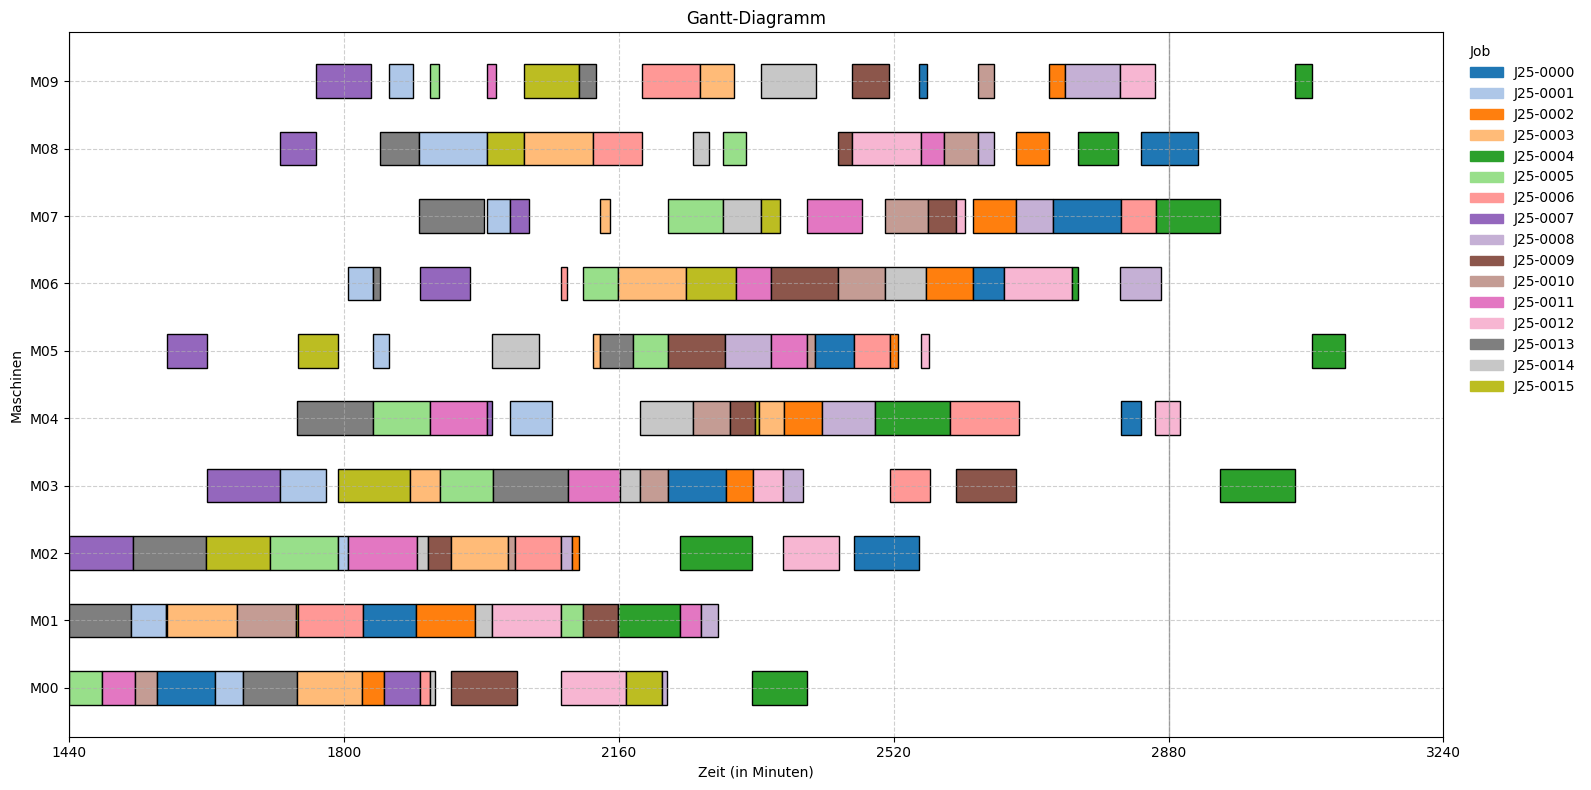

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [11]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:43:00] Job J25-0005 finished on M00 (after 43 minutes)
[Day 1 00:43:00] Job J25-0011 started on M00
[Day 1 01:08:00] Job J25-0013 finished on M01 (after 68 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:25:00] Job J25-0011 finished on M00 (after 42 minutes)
[Day 1 01:26:00] Job J25-0010 started on M00
[Day 1 01:30:00] Job J25-0007 finished on M02 (after 90 minutes)
[Day 1 01:30:00] Job J25-0013 started on M02
[Day 1 01:50:00] Job J25-0010 finished on M00 (after 24 minutes)
[Day 1 01:55:00] Job J25-0000 started on M00
[Day 1 02:03:00] Job J25-0001 finished on M01 (after 42 minutes)
[Day 1 02:07:00] Job J25-0007 started on M01
[Day 1 02:09:00] Job J25-0007 finished on M01 (after 02 minutes)
[Day 1 02:09:00] Job J25-0003 started on M01
[Day 1 02:09:00] Job J25-0007 started on M05
[Day 1 03:06:00] Job J25-0007 finished on M05 (aft

In [12]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,0,M00,1555.0,81.0,1636.0
1,J25-0000,8,79,1,M01,1825.0,61.0,1886.0
2,J25-0000,8,79,2,M03,2234.0,71.0,2305.0
3,J25-0000,8,79,3,M05,2451.0,42.0,2493.0
4,J25-0000,8,79,4,M02,2493.0,72.0,2565.0
5,J25-0000,8,79,5,M09,2565.0,8.0,2573.0
...,...,...,...,...,...,...,...,...
147,J25-0015,5,1436,4,M08,1988.0,44.0,2032.0
148,J25-0015,5,1436,5,M09,2059.0,74.0,2133.0
149,J25-0015,5,1436,6,M00,2170.0,55.0,2225.0


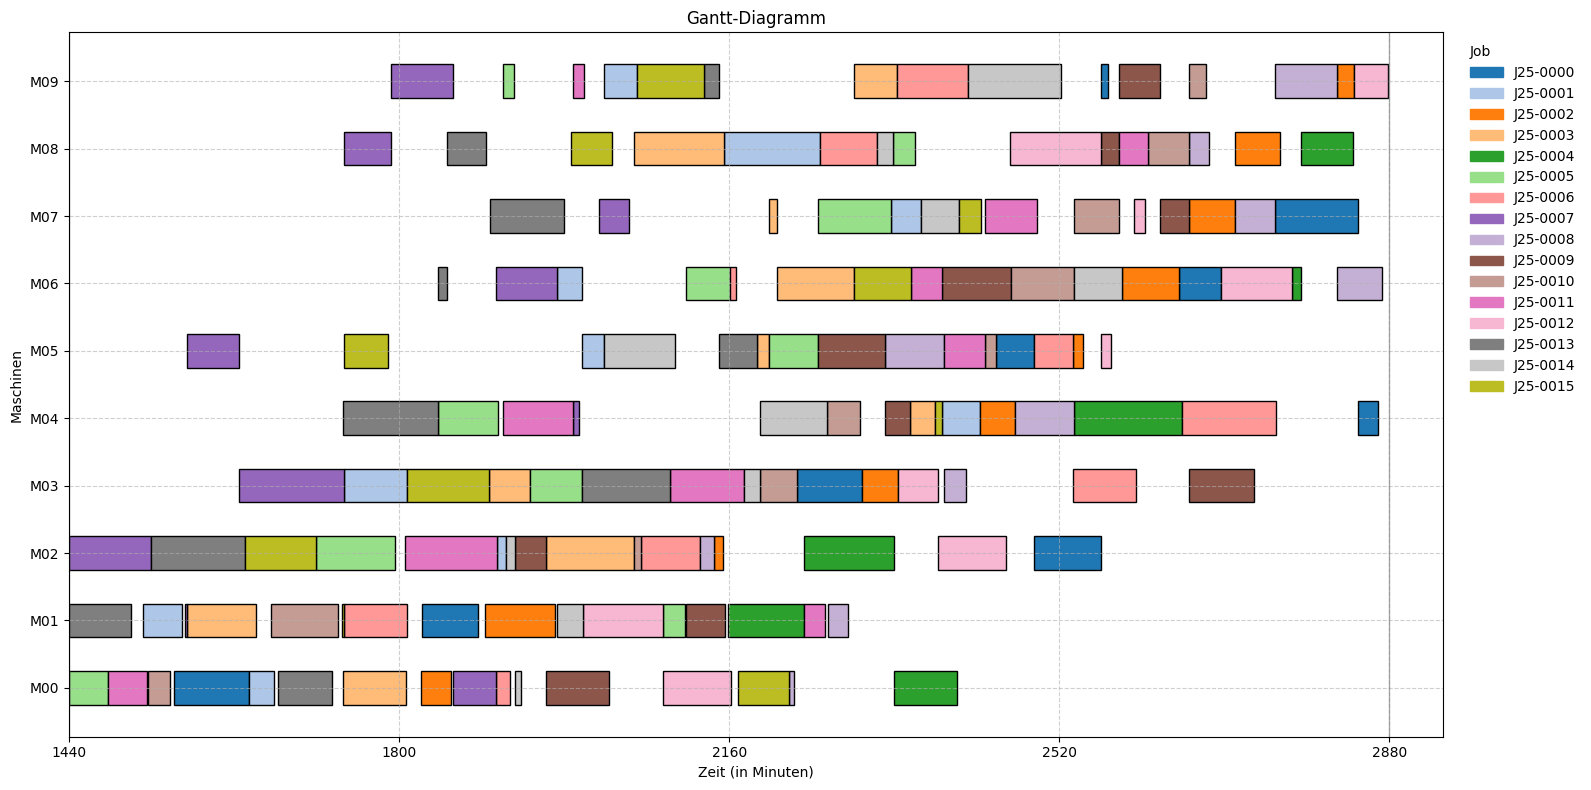

In [13]:
show.plot_gantt(df_execution, perspective="Machine")

In [14]:
df_active = simulation.get_active_operations_df()
df_active

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,8,J25-0000,9,M08,79,2868.0,74,76.0,2942.0,2944.0
1,9,J25-0006,9,M07,790,2846.0,45,37.0,2891.0,2883.0
2,2,J25-0012,9,M04,1103,2879.0,33,30.0,2912.0,2909.0


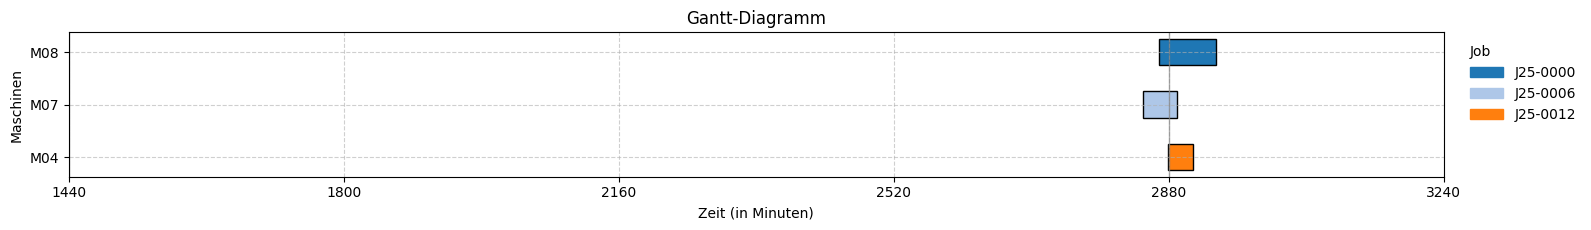

In [15]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [16]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0004,3,287,1440,4856,6,M07,2863,85,2948
1,J25-0004,3,287,1440,4856,7,M03,2948,98,3046
2,J25-0004,3,287,1440,4856,8,M09,3046,22,3068
3,J25-0004,3,287,1440,4856,9,M05,3068,43,3111


#### b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.

In [17]:
# Scheduling
df_schedule_b = cp_tard_schedule.solve_jssp_max(
    df_jssp_current, df_jobs_times_current, earliest_start_column = "Ready Time",
    msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule_b


Solver-Status        : OPTIMAL
Maximale Tardiness     : 0.0
Best Objective Bound   : 0.0
Laufzeit               : 0.04 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0005,1,498,1440,3106,0,M00,1440,43,1483
1,J25-0007,5,925,1440,2929,0,M02,1440,84,1524
2,J25-0013,3,1192,1440,2567,0,M01,1440,81,1521
3,J25-0011,1,1030,1440,3210,0,M00,1483,43,1526
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0013,3,1192,1440,2567,1,M02,1524,95,1619
...,...,...,...,...,...,...,...,...,...,...
154,J25-0000,8,79,1440,3660,9,M08,2844,74,2918
155,J25-0012,2,1103,1440,4385,9,M04,2862,33,2895
156,J25-0004,3,287,1440,4856,6,M07,2863,85,2948


## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [18]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [19]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
4,J25-0004,3,287,1440,2697.0,655,4856
16,J25-0016,6,1500,2880,3858.0,416,4558
17,J25-0017,7,1864,2880,4621.0,539,4980
18,J25-0018,8,1919,2880,4147.0,597,4772
19,J25-0019,9,1925,2880,4352.0,540,4621
20,J25-0020,1,1935,2880,4322.0,510,4834
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [20]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
46,J25-0004,3,6,M07,85
47,J25-0004,3,7,M03,98
48,J25-0004,3,8,M09,22
49,J25-0004,3,9,M05,43
160,J25-0016,6,0,M01,46
161,J25-0016,6,1,M00,37
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [21]:
df_schedule_simple = cp_tard_reschedule.solve_jssp_sum_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = day_start, msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple


Solver-Status         : OPTIMAL
Summe Tardiness       : 0.0
Best Objective Bound  : 0.0
Laufzeit              : 0.09 Sekunden


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0031,1,2567,2880,4377,0,M00,2880,43,2923
1,J25-0032,6,2654,2880,3881,0,M01,2880,46,2926
2,J25-0035,5,2726,2880,4126,0,M02,2880,84,2964
3,J25-0004,3,287,1440,4856,6,M07,2883,85,2968
4,J25-0023,8,2055,2880,4676,0,M00,2923,76,2999
5,J25-0026,6,2192,2880,4415,0,M01,2926,46,2972
...,...,...,...,...,...,...,...,...,...,...
218,J25-0033,2,2660,2880,6738,6,M07,4749,12,4761
219,J25-0034,8,2715,2880,6387,8,M04,4749,26,4775
220,J25-0033,2,2660,2880,6738,7,M06,4761,89,4850


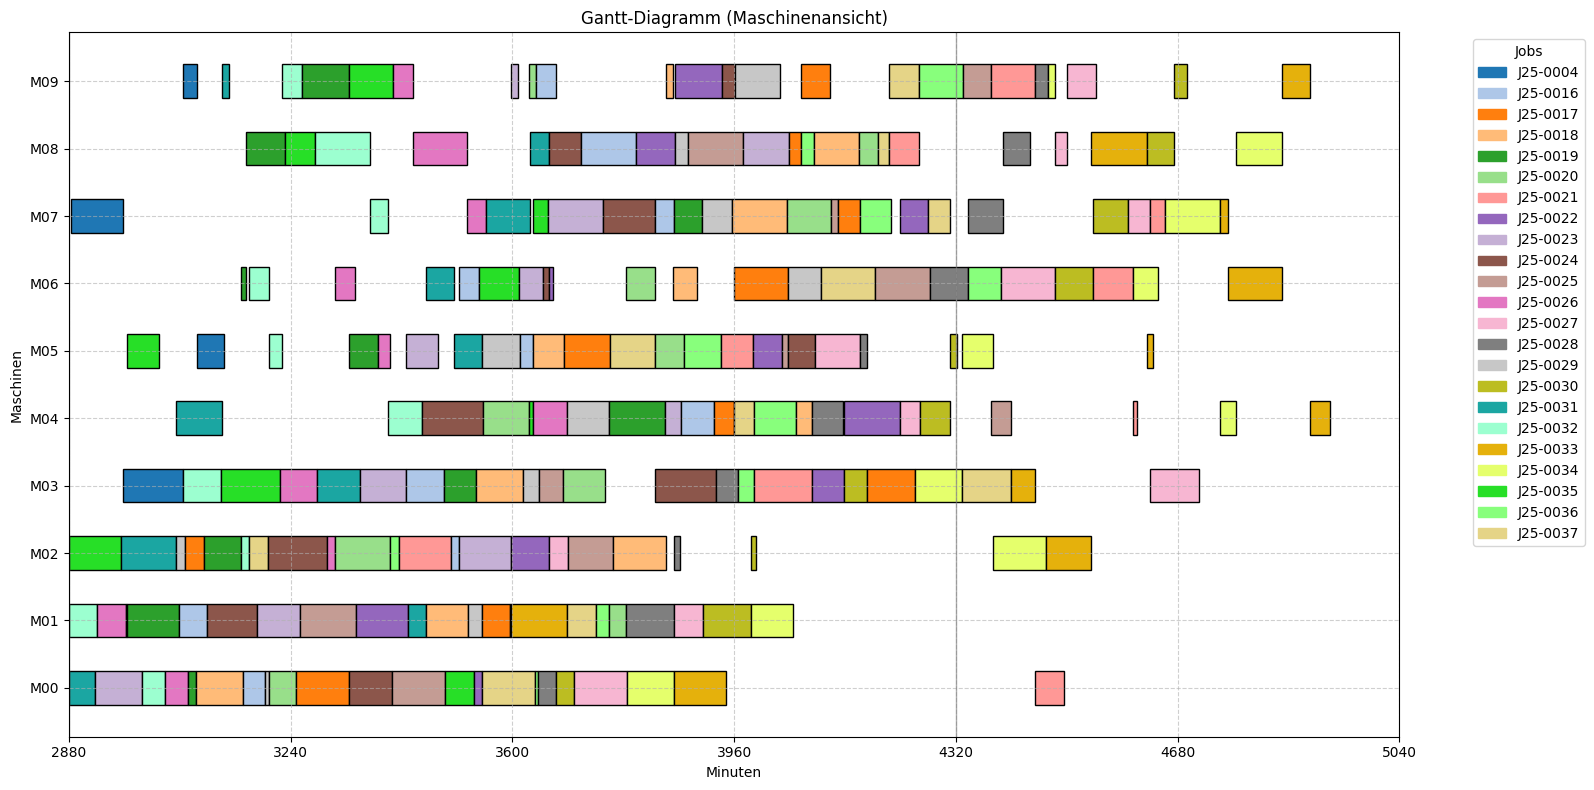

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

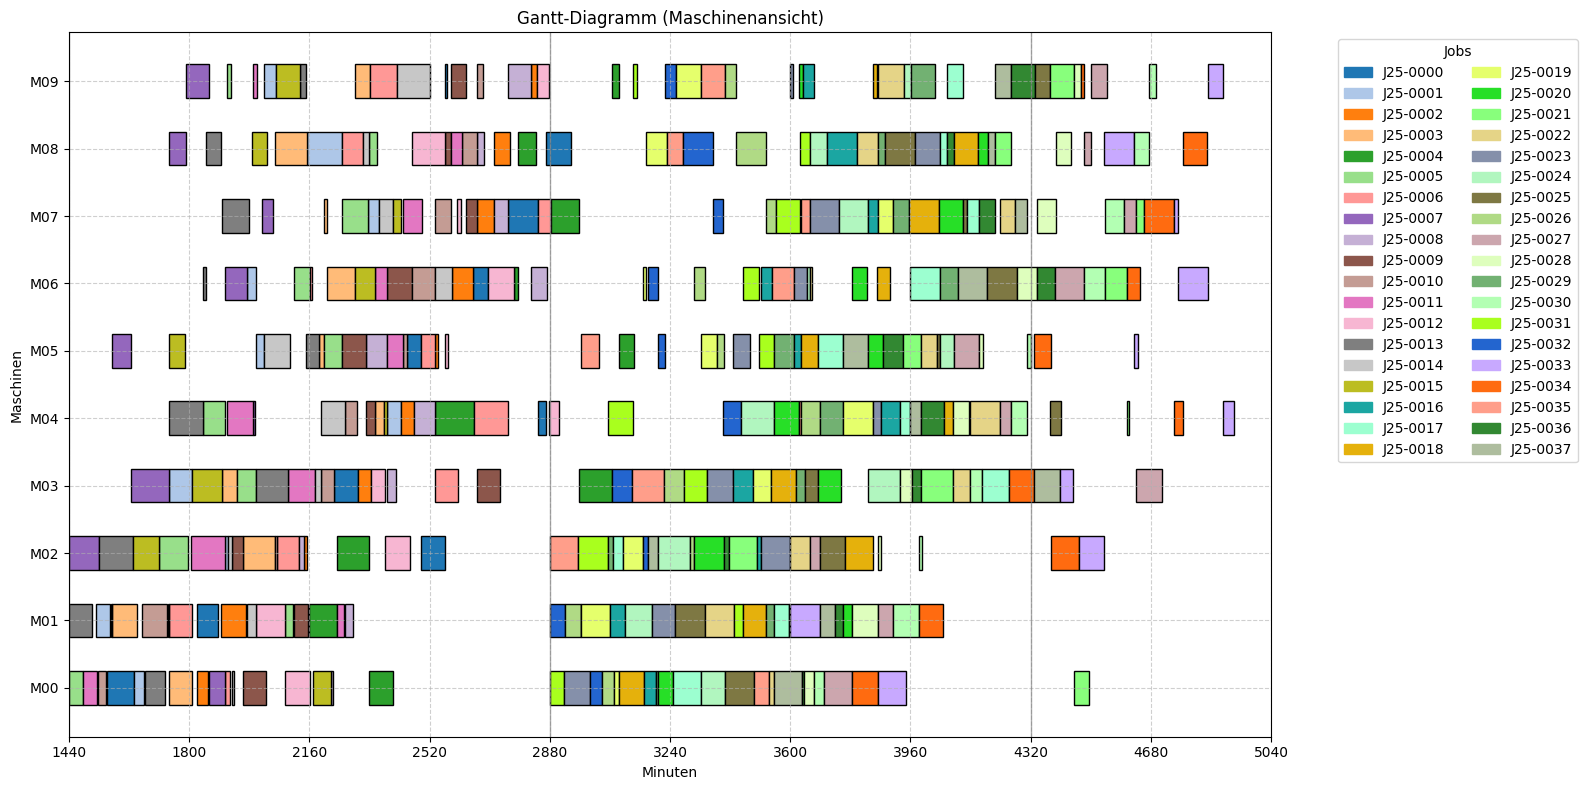

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [24]:
df_schedule_devpen = cp_tard_reschedule.solve_jssp_sum_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start,
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen


Solver-Status         : OPTIMAL
Objective Value       : 3200.00
Best Objective Bound  : 3200.00
Laufzeit              : 0.06 Sekunden
Deviation terms       : 4


,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0031,1,2567,2880,4377,0,M00,2880,43,2923
1,J25-0032,6,2654,2880,3881,0,M01,2880,46,2926
2,J25-0035,5,2726,2880,4126,0,M02,2880,84,2964
3,J25-0004,3,287,1440,4856,6,M07,2883,85,2968
4,J25-0023,8,2055,2880,4676,0,M00,2923,76,2999
5,J25-0026,6,2192,2880,4415,0,M01,2926,46,2972
...,...,...,...,...,...,...,...,...,...,...
218,J25-0033,2,2660,2880,6738,6,M07,4749,12,4761
219,J25-0034,8,2715,2880,6387,8,M04,4749,26,4775
220,J25-0033,2,2660,2880,6738,7,M06,4761,89,4850


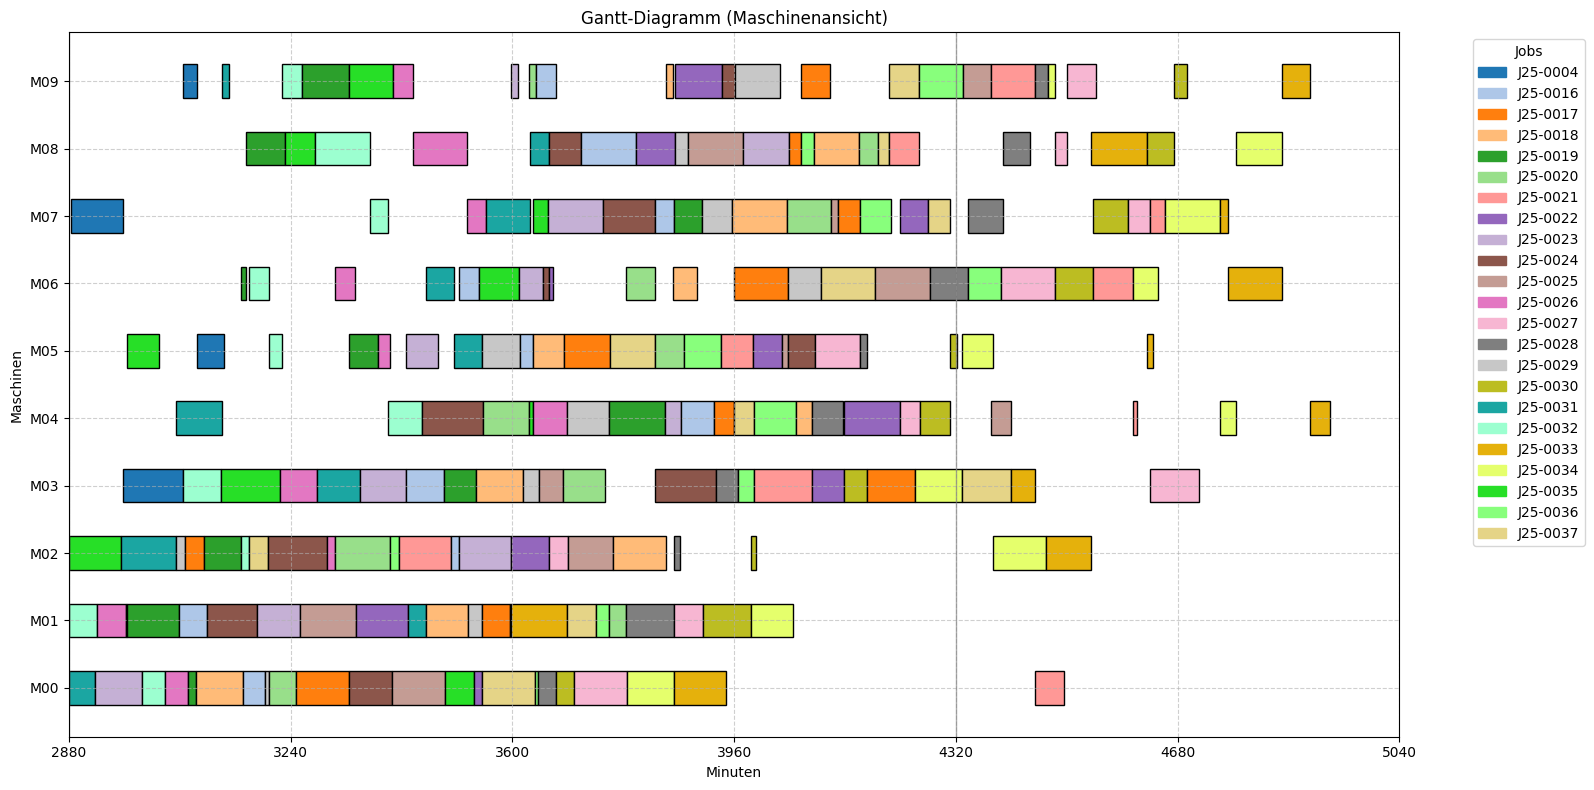

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [25]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

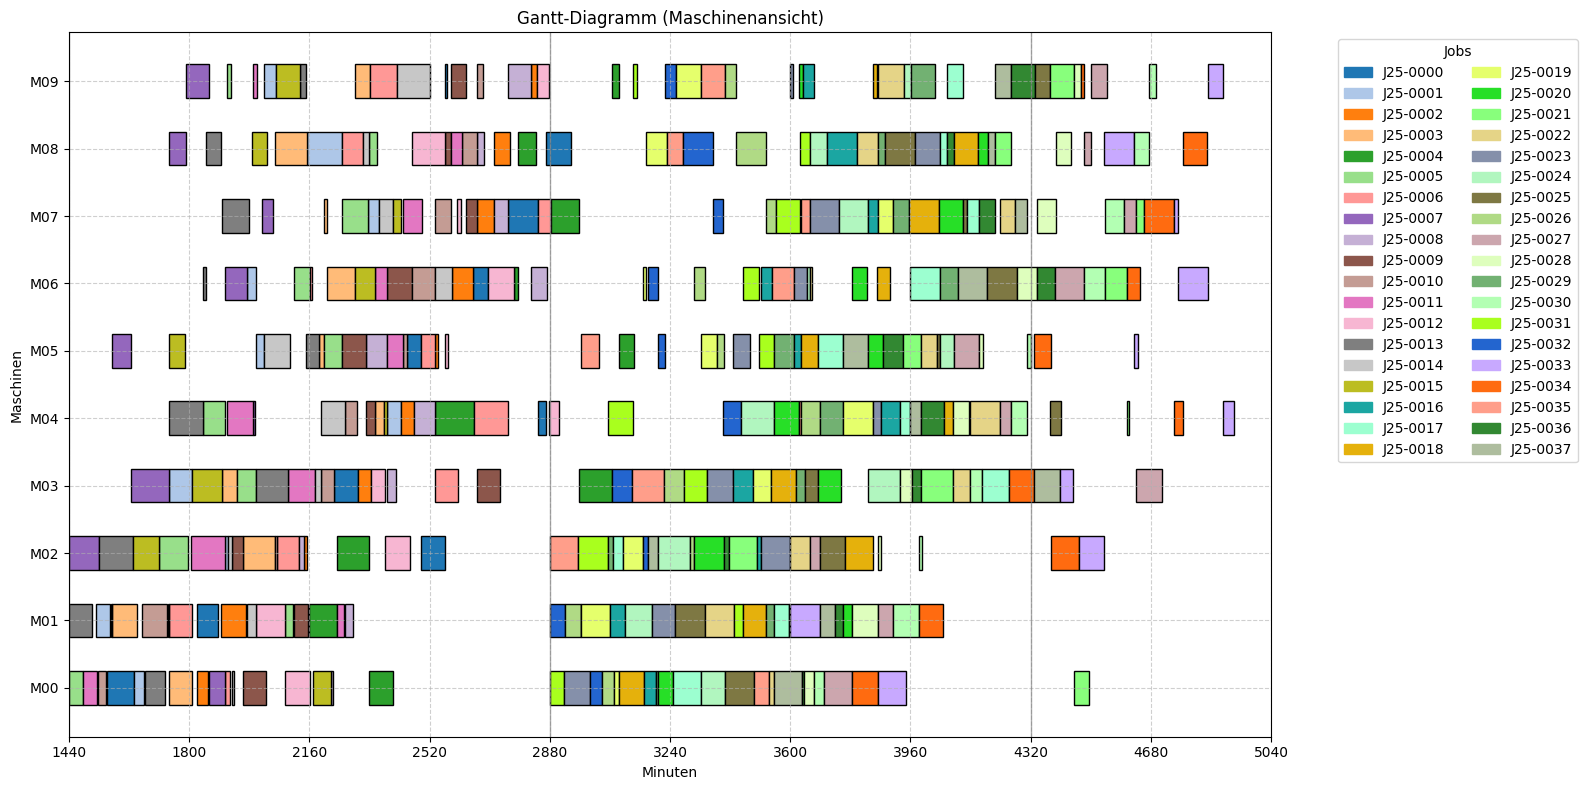

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [26]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [27]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0006, Operation 9 resumed with 3.00 min
[Day 2 00:00:00] Job J25-0000, Operation 9 resumed with 64.00 min
[Day 2 00:00:00] Job J25-0012, Operation 9 resumed with 29.00 min
[Day 2 00:00:00] Job J25-0031 started on M00
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:03:00] Job J25-0006 finished on M07 (after 03 minutes)
[Day 2 00:03:00] Job J25-0004 started on M07
[Day 2 00:29:00] Job J25-0012 finished on M04 (after 29 minutes)
[Day 2 00:35:00] Job J25-0032 finished on M01 (after 35 minutes)
[Day 2 00:41:00] Job J25-0031 finished on M00 (after 41 minutes)
[Day 2 00:43:00] Job J25-0023 started on M00
[Day 2 00:46:00] Job J25-0026 started on M01
[Day 2 01:04:00] Job J25-0000 finished on M08 (after 64 minutes)
[Day 2 01:27:00] Job J25-0026 finished on M01 (after 41 minutes)
[Day 2 01:34:00] Job J25-0019 started on M01
[Day 2 01:39:00] Job J25-0004 finished on M07 (after 96 minutes)
[Day 2 01:39:00] Job J25-0004 sta

In [28]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,9,M08,2868.0,76.0,2944.0
1,J25-0004,3,287,6,M07,2883.0,96.0,2979.0
2,J25-0004,3,287,7,M03,2979.0,94.0,3073.0
3,J25-0004,3,287,8,M09,3073.0,21.0,3094.0
4,J25-0004,3,287,9,M05,3094.0,42.0,3136.0
5,J25-0006,9,790,9,M07,2846.0,37.0,2883.0
...,...,...,...,...,...,...,...,...
176,J25-0037,7,2801,1,M00,3580.0,99.0,3679.0
177,J25-0037,7,2801,2,M01,3689.0,40.0,3729.0
178,J25-0037,7,2801,3,M05,3759.0,77.0,3836.0


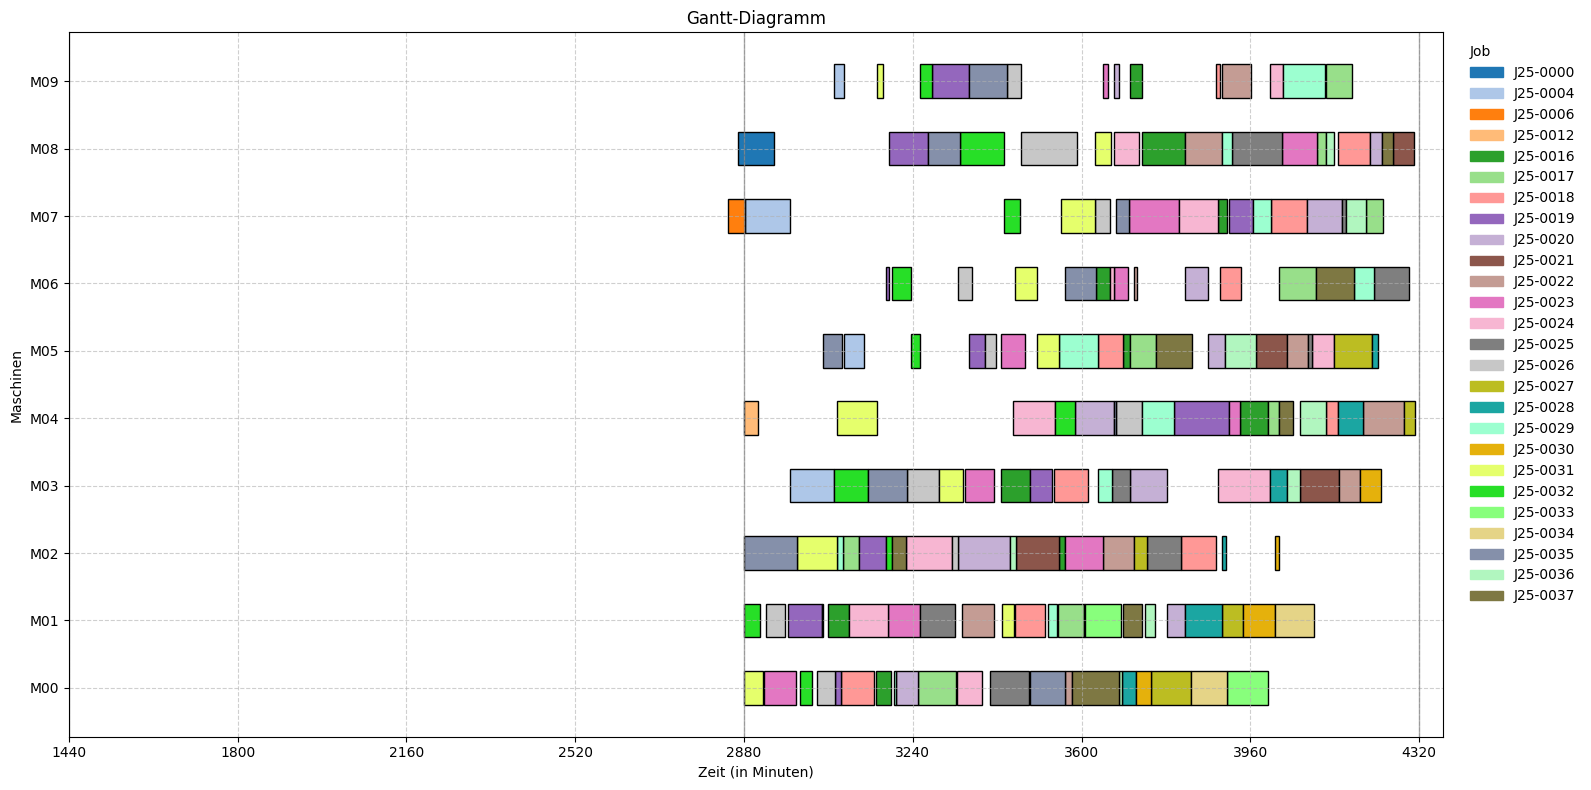

In [29]:
show.plot_gantt(df_execution2, perspective="Machine")

In [30]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,7,J25-0017,9,M03,1864,4242.0,79,85.0,4321.0,4327.0
1,9,J25-0022,9,M07,2001,4288.0,45,47.0,4333.0,4335.0
2,0,J25-0028,6,M06,2282,4298.0,62,79.0,4360.0,4377.0
3,0,J25-0030,4,M04,2313,4312.0,49,37.0,4361.0,4349.0
4,4,J25-0036,8,M09,2734,4260.0,72,78.0,4332.0,4338.0


In [31]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,0,M00,1555,76,1631
1,J25-0000,8,79,1440,3660,1,M01,1825,69,1894
2,J25-0000,8,79,1440,3660,2,M03,2224,76,2300
3,J25-0000,8,79,1440,3660,3,M05,2417,51,2468
4,J25-0000,8,79,1440,3660,4,M02,2468,85,2553
5,J25-0000,8,79,1440,3660,5,M09,2553,11,2564
...,...,...,...,...,...,...,...,...,...,...
147,J25-0015,5,1436,1440,2981,4,M08,1988,48,2036
148,J25-0015,5,1436,1440,2981,5,M09,2036,72,2108
149,J25-0015,5,1436,1440,2981,6,M00,2170,47,2217


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

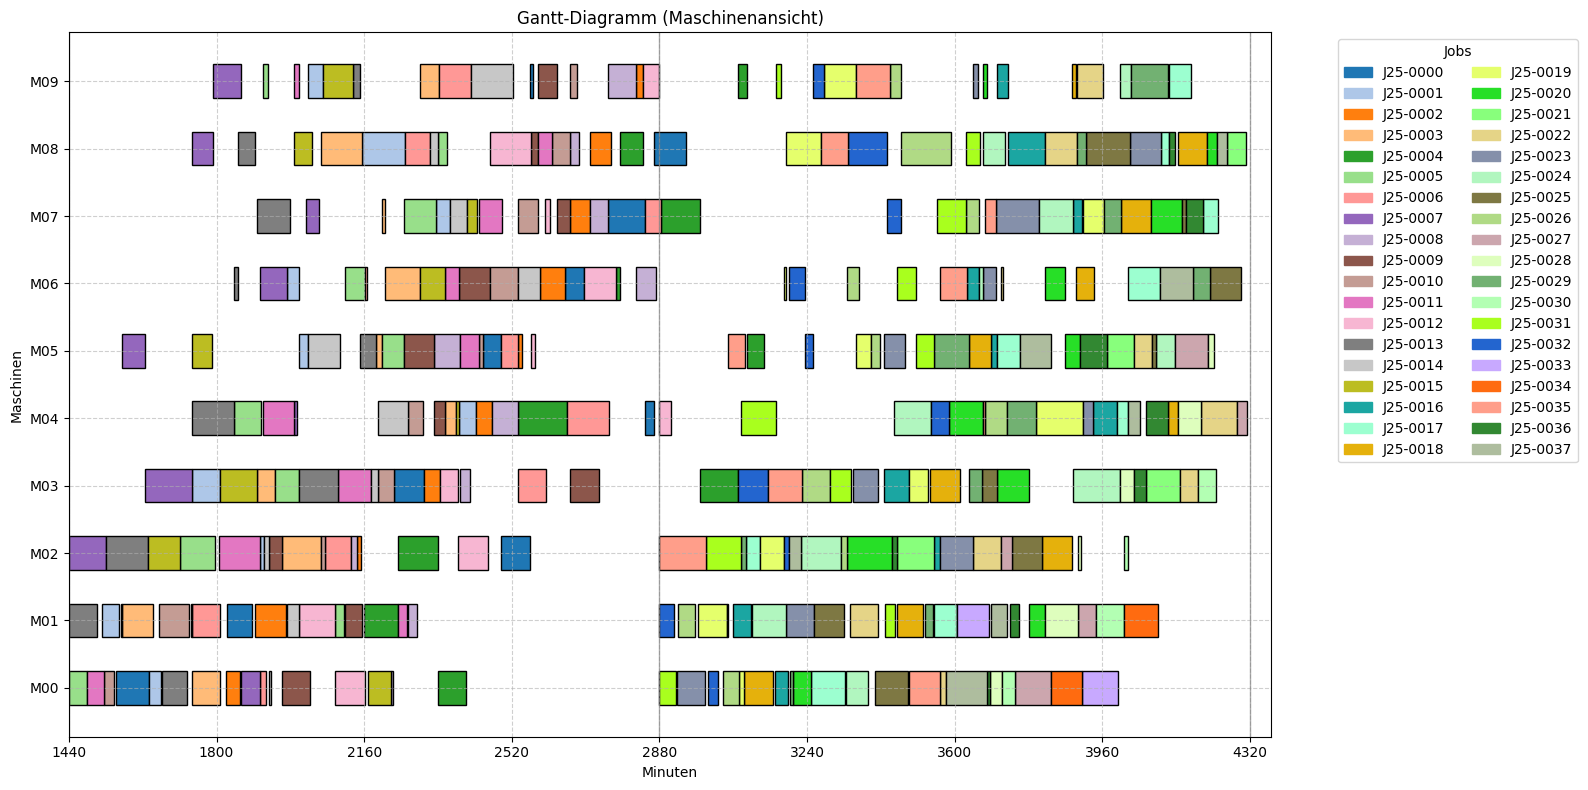

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [32]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)